<a href="https://colab.research.google.com/github/wesleyroseno/colaboratory/blob/main/Curso_NVIDIA_RAPIDS_Dask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dask e RAPIDS

Documentação: https://docs.dask.org/en/stable/

## Instalação

In [ ]:
# não é mais necessário, pois o dask já vem junto no pacote de instalação abaixo
#!pip install dask
#!pip install dask_cuda

In [ ]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 390, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 390 (delta 89), reused 51 (delta 51), pack-reused 269
Receiving objects: 100% (390/390), 107.11 KiB | 17.85 MiB/s, done.
Resolving deltas: 100% (191/191), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 867.7 kB/s eta 0:00:00
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
We will now install RAPIDS cuDF, cuML, and cuGraph via pip! 
Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.6/499.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 GB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import cudf, cuml
import dask, dask_cudf
print('Dask: ', dask.__version__)
print('Dask cuDF:', dask_cudf.__version__)

Dask:  2023.7.1
Dask cuDF: 23.08.00


## Criando um cluster local


In [ ]:
from dask.distributed import Client, LocalCluster, wait, progress

In [ ]:
from dask_cuda import LocalCUDACluster

* Dask-CUDA: https://docs.rapids.ai/api/dask-cuda/stable/quickstart.html
* Deploy Dask clusters in the cloud: https://docs.dask.org/en/stable/deploying.html#cloud
* Dask documentation: https://docs.dask.org/en/stable/deploying.html#distributed-computing


In [ ]:
cluster = LocalCUDACluster(threads_per_worker = 1)
client = Client(cluster)
client

INFO:distributed.http.proxy:To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:45163
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:8787/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:40157'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:33481', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:33481
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:33126
INFO:distributed.scheduler:Receive client connection: Client-eb6f2f68-56e4-11ee-81e3-0242ac1c000c
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:33136


Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 1,Total memory: 12.68 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45163,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 1
Started: Just now,Total memory: 12.68 GiB
Comm: tcp://127.0.0.1:33481,Total threads: 1
Dashboard: http://127.0.0.1:35345/status,Memory: 12.68 GiB
Nanny: tcp://127.0.0.1:40157,


Os workers possuem basicamente duas funções:
1. Calcular tarefas conforme indicado pelo scheduler
2. Armazenar e fornecer resultados computados para outros workers ou clientes

* Cada worker contém um ThreadPool, que usa para avaliar tarefas conforme solicitado pelo scheduler. O worker armazena os resultados dessas tarefas localmente e os fornece a outros workers ou clientes sob demanda.
Se for solicitado ao worker que avalie uma tarefa para a qual não possui todos os dados necessários, ele entrará em contato com seus pares para reunir as dependências necessárias.

* Cada worker envia cálculos para uma thread em concurrent.futures.ThreadPoolExecutor para a realização do cálculo. Esses cálculos ocorrem no mesmo processo que o servidor de comunicação Worker para que eles possam acessar e compartilhar dados de forma eficiente entre si. Para fins de localidade de dados, todos as threads dentro de um worker são considerados o mesmo worker.

Mais sobre workers: https://distributed.dask.org/en/latest/worker.html

O Dask vai carregar todo o código que processarmos dentro dele e posteriormente vai paralelizar e distribuir esse código. E na hora que precisarmos que de fato calcule, nós enviamos um comando para executar o código.  


## Arrays de GPU distribuídas



In [ ]:
import dask.array as da
import cupy as cp

In [ ]:
rs = da.random.RandomState(RandomState=cp.random.RandomState, seed = 42)
x = rs.random((100000, 1000), chunks=(10000, 1000))
x = x.persist()

In [ ]:
x

dask.array<random_sample, shape=(100000, 1000), dtype=float64, chunksize=(10000, 1000), chunktype=cupy.ndarray>

In [ ]:
# Decomposição em valores singulares
https://pt.wikipedia.org/wiki/Decomposi%C3%A7%C3%A3o_em_valores_singulares

In [ ]:
u, s, v = da.linalg.svd(x)

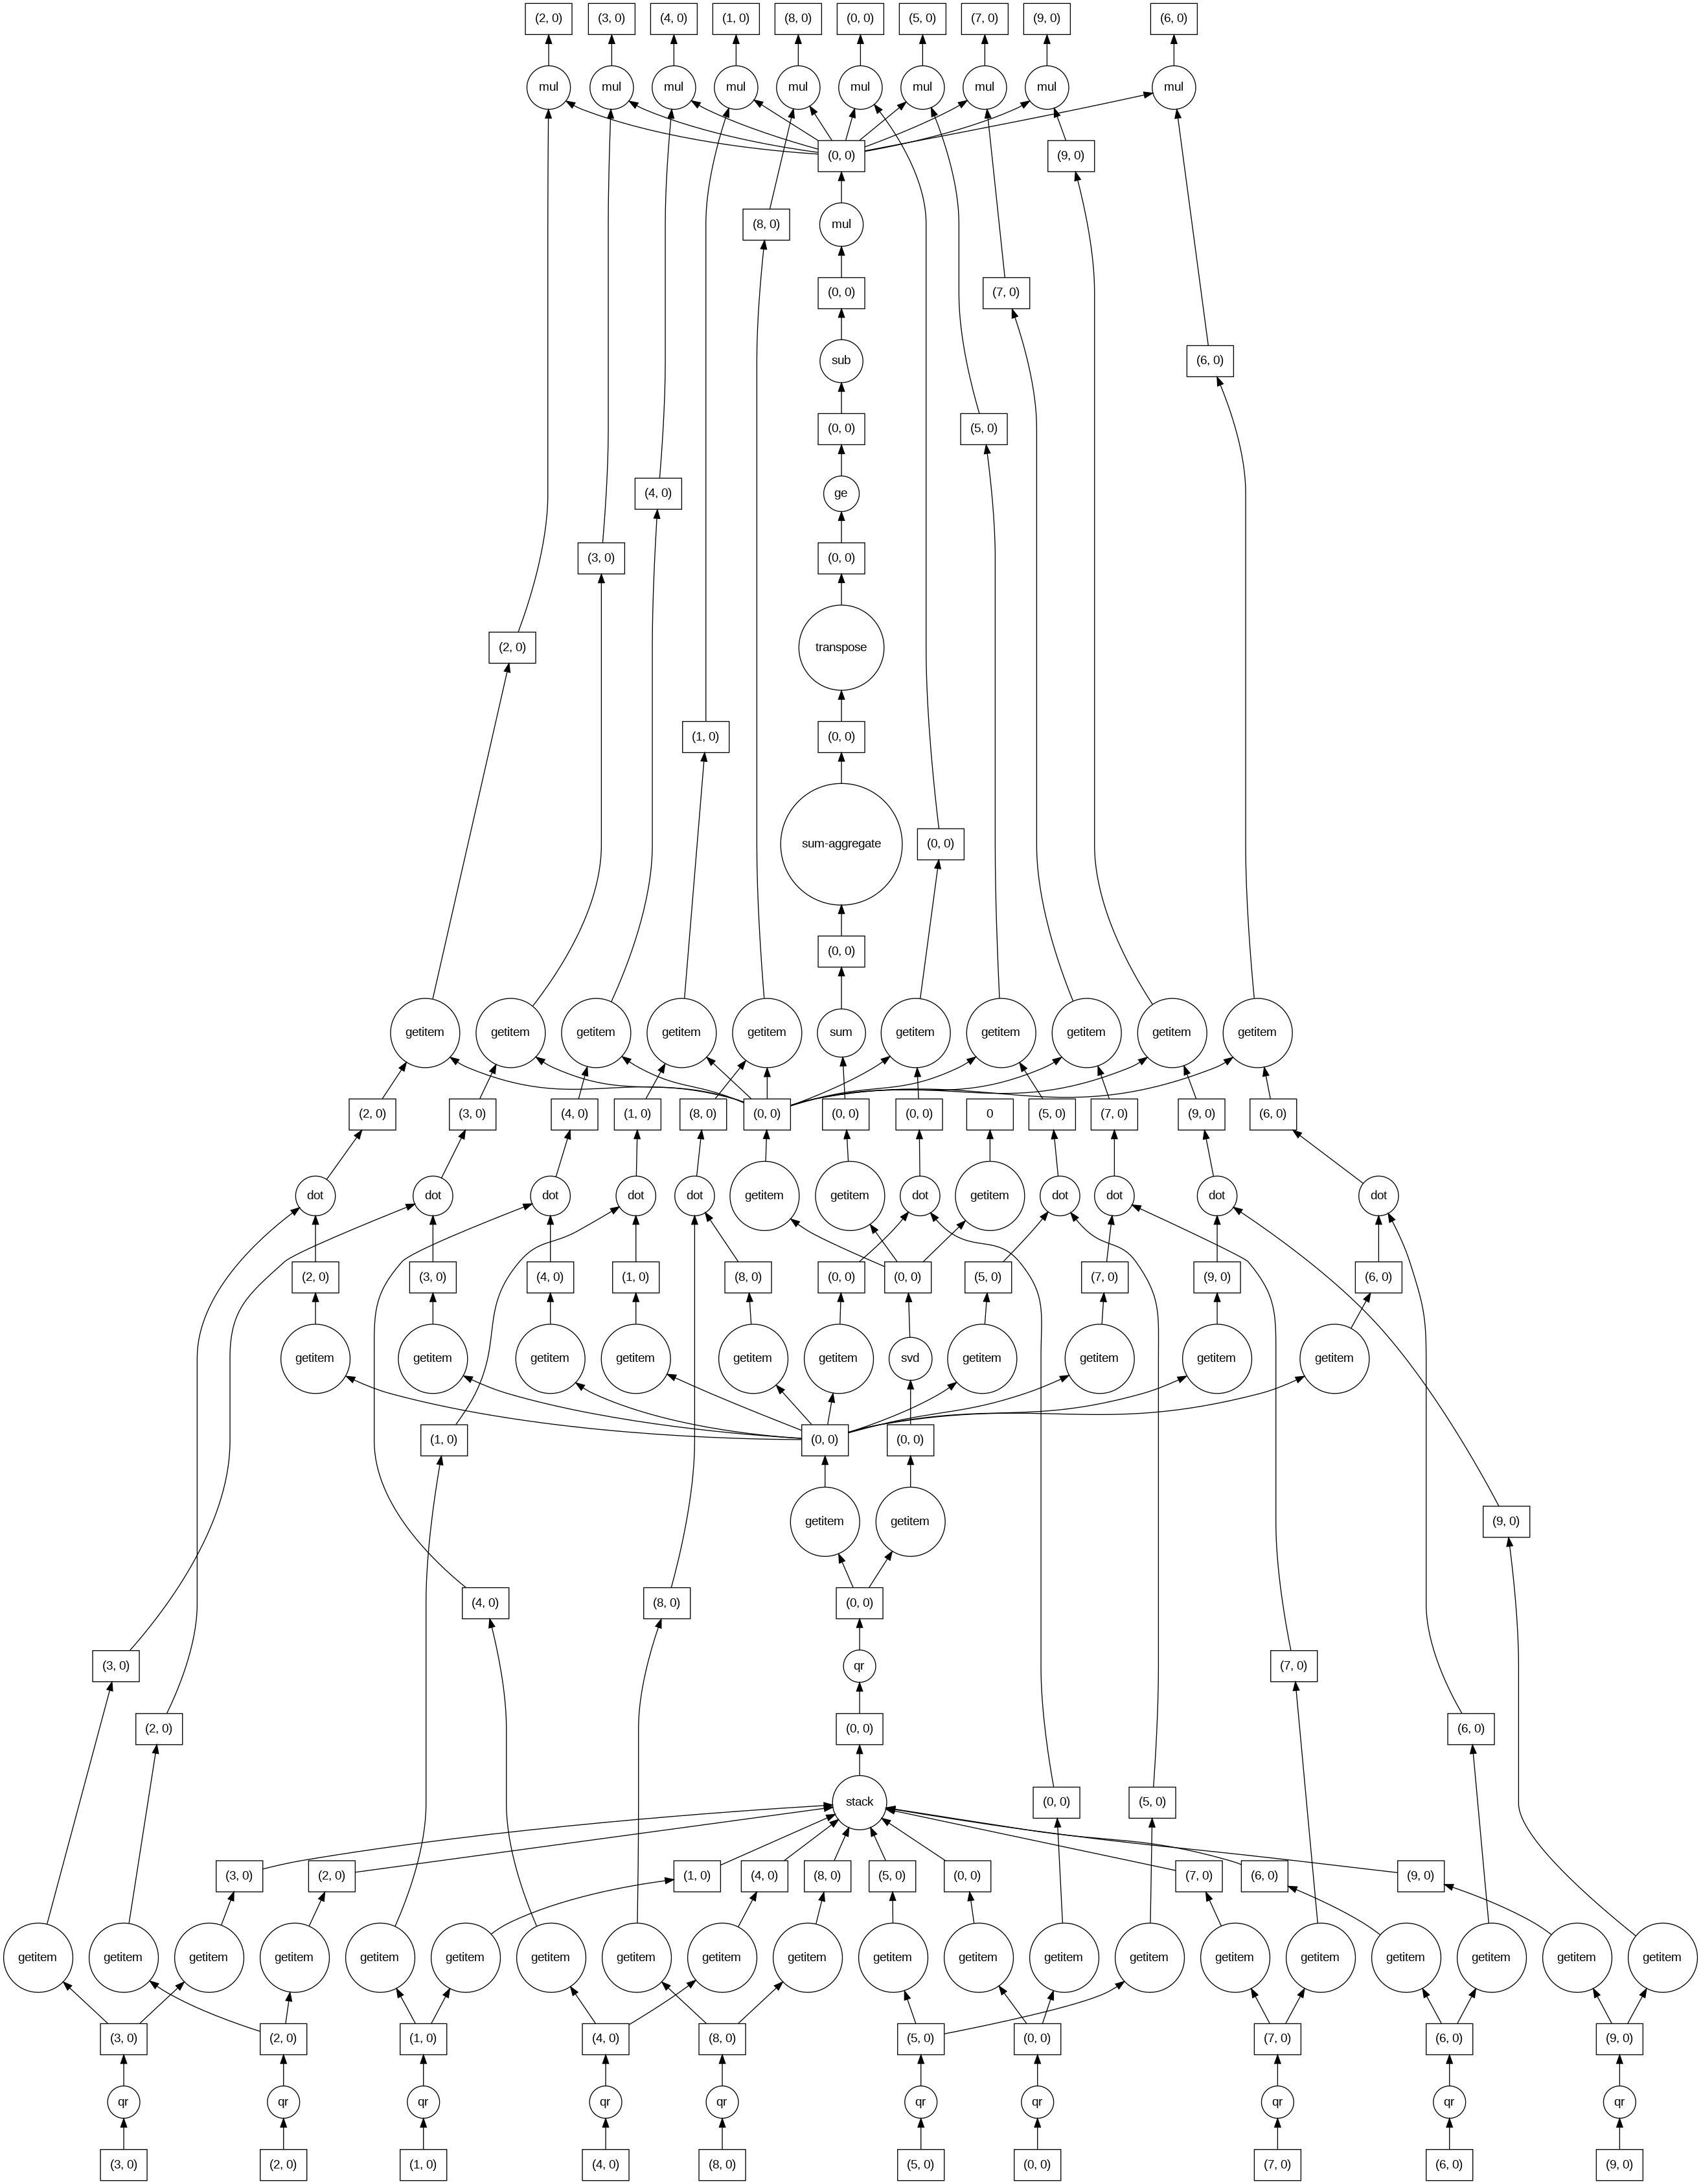

In [ ]:
u.visualize()

In [ ]:
u, s, v = dask.persist(u, s, v)

# Dask e CuDF

## Criação de objeto

In [ ]:
s = cudf.Series([1,2,None,3,4])
s

0       1
1       2
2    <NA>
3       3
4       4
dtype: int64

In [ ]:
s.head()

0       1
1       2
2    <NA>
3       3
4       4
dtype: int64

In [ ]:
ds = dask_cudf.from_cudf(s, npartitions=2)

In [ ]:
ds.head()

0       1
1       2
2    <NA>
dtype: int64

In [ ]:
ds.head(n=5)

0       1
1       2
2    <NA>
dtype: int64

In [ ]:
df = cudf.DataFrame(
    {'a': list(range(10)),
     'b': list(reversed(range(10))),
     'c': list(range(10))})
df

,a,b,c
0,0,9,0
1,1,8,1
2,2,7,2
3,3,6,3
4,4,5,4
5,5,4,5
6,6,3,6
7,7,2,7
8,8,1,8
9,9,0,9


In [ ]:
ddf = dask_cudf.from_cudf(df, npartitions=2)
ddf.head()

,a,b,c
0,0,9,0
1,1,8,1
2,2,7,2
3,3,6,3
4,4,5,4


In [ ]:
ddf.compute()

,a,b,c
0,0,9,0
1,1,8,1
2,2,7,2
3,3,6,3
4,4,5,4
5,5,4,5
6,6,3,6
7,7,2,7
8,8,1,8
9,9,0,9


## Ordenando os dados


In [ ]:
type(df)

cudf.core.dataframe.DataFrame

In [ ]:
df.sort_values(by='b')

,a,b,c
9,9,0,9
8,8,1,8
7,7,2,7
6,6,3,6
5,5,4,5
4,4,5,4
3,3,6,3
2,2,7,2
1,1,8,1
0,0,9,0


In [ ]:
type(ddf)

dask_cudf.core.DataFrame

In [ ]:
ddf.sort_values(by='b').head()

,a,b,c
9,9,0,9
8,8,1,8
7,7,2,7
6,6,3,6


In [ ]:
ddf.sort_values(by='b').compute()

,a,b,c
9,9,0,9
8,8,1,8
7,7,2,7
6,6,3,6
5,5,4,5
4,4,5,4
3,3,6,3
2,2,7,2
1,1,8,1
0,0,9,0


## Seleção


In [ ]:
ddf['a'].head()

0    0
1    1
2    2
3    3
4    4
Name: a, dtype: int64

In [ ]:
ddf.loc[2:4, ['a', 'b']].head()

,a,b
2,2,7
3,3,6
4,4,5


## Condicionamentos e indexação booleana


In [ ]:
ddf[ddf.b > 7].head(n = 3)

,a,b,c
0,0,9,0
1,1,8,1


In [ ]:
ddf.query("b == 9").compute()

,a,b,c
0,0,9,0


## Gravação e leitura de dados

In [ ]:
ddf.compute().to_csv('exemplo_dask.csv', index = False)

In [ ]:
df = cudf.read_csv('/content/exemplo_dask.csv')
df

,a,b,c
0,0,9,0
1,1,8,1
2,2,7,2
3,3,6,3
4,4,5,4
5,5,4,5
6,6,3,6
7,7,2,7
8,8,1,8
9,9,0,9


# Dask e CuML

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn import model_selection, datasets

from cuml.dask.common import utils as dask_utils
from dask.distributed import Client, wait
from dask_cuda import LocalCUDACluster
import dask_cudf

from cuml.dask.ensemble import RandomForestClassifier as RF_cumlDask
from sklearn.ensemble import RandomForestClassifier as RF_skl

import pandas as pd
import numpy as np

## Criando o Cluster Local

In [ ]:
cluster = LocalCUDACluster(threads_per_worker=1)
c = Client(cluster)

/usr/local/lib/python3.10/dist-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39267 instead
  warnings.warn(
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:46837
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:39267/status
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:41323'
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:42753', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:42753
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:40262
INFO:distributed.scheduler:Receive client connection: Client-58f182ae-56ed-11ee-81e3-0242ac1c000c
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:40274


In [ ]:
workers = c.has_what().keys()
n_workers = len(workers)
n_streams = 8

In [ ]:
workers

dict_keys(['tcp://127.0.0.1:42753'])

## Definição dos parâmetros


In [ ]:
train_size = 100000
test_size = 1000
n_samples = train_size + test_size
n_features = 20

In [ ]:
max_depth = 12
n_bins = 16
n_trees = 1000

#  https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/

## Gerar dados no host


In [ ]:
20 / 3

6.666666666666667

In [ ]:
X, y = datasets.make_classification(n_samples = n_samples, n_features=n_features,
                                    random_state = 42, n_classes=5,
                                    n_informative=int(n_features / 3))

In [ ]:
X = X.astype(np.float32)
y = y.astype(np.int32)
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=test_size)

In [ ]:
X_train.shape, y_train.shape

((100000, 20), (100000,))

In [ ]:
X_test.shape, y_test.shape

((1000, 20), (1000,))

In [ ]:
type(X_train)

numpy.ndarray

## Distribuir os dados


In [ ]:
n_workers

1

In [ ]:
n_partitions = n_workers

def distribute(X, y):
  X_cudf = cudf.DataFrame.from_pandas(pd.DataFrame(X))
  y_cudf = cudf.Series(y)

  X_dask = dask_cudf.from_cudf(X_cudf, npartitions=n_partitions)
  y_dask = dask_cudf.from_cudf(y_cudf, npartitions=n_partitions)

  X_dask, y_dask = dask_utils.persist_across_workers(c, [X_dask, y_dask], workers=workers)

  return X_dask, y_dask

In [ ]:
X_train_dask, y_train_dask = distribute(X_train, y_train)
X_test_dask, y_test_dask = distribute(X_test, y_test)

In [ ]:
type(X_train_dask)

dask_cudf.core.DataFrame

## Na CPU com o Scikit-learn

In [ ]:
type(X_train), type(y_train)

(numpy.ndarray, numpy.ndarray)

In [ ]:
skl_model = RF_skl(max_depth=max_depth, n_estimators=n_trees, n_jobs=-1, verbose=True)
skl_model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  7.0min finished


RandomForestClassifier(max_depth=12, n_estimators=1000, n_jobs=-1, verbose=True)

## Na GPU com o cuML + Dask


In [ ]:
type(X_train_dask), type(y_train_dask)

(dask_cudf.core.DataFrame, dask_cudf.core.Series)

In [ ]:
cuml_model = RF_cumlDask(max_depth=max_depth, n_estimators=n_trees, n_bins=n_bins, n_streams=n_streams)
cuml_model.fit(X_train_dask, y_train_dask)
wait(cuml_model.rfs)

DoneAndNotDoneFutures(done={<Future: finished, type: cuml.ensemble.randomforestclassifier.RandomForestClassifier, key: _construct_rf-faa5d3fa-e552-4902-aa1e-d5ecb444b1cb>}, not_done=set())

## Predição (testando o modelo)

In [ ]:
cuml_model.predict(X_test_dask).compute()

/usr/local/lib/python3.10/dist-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 32.29 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 32.22 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


0      4.0
1      1.0
2      1.0
3      4.0
4      0.0
      ... 
995    4.0
996    4.0
997    2.0
998    3.0
999    1.0
Length: 1000, dtype: float32

In [ ]:
skl_y_pred = skl_model.predict(X_test)
cuml_y_pred = cuml_model.predict(X_test_dask).compute().to_numpy()

skl_accuracy = accuracy_score(y_test, skl_y_pred)
cuml_accuracy = accuracy_score(y_test, cuml_y_pred)

print("SKLearn: {}".format(skl_accuracy))
print("CuML: {}".format(cuml_accuracy))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 1000 out of 1000 | elapsed:    0.5s finished
/usr/local/lib/python3.10/dist-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 32.29 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/distributed/client.py:3141: UserWarning: Sending large graph of size 32.22 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


SKLearn: 0.794
CuML: 0.751


## Salvando o modelo

In [ ]:
import pickle

pickle.dump(cuml_model, open("model_RF.pkl", "wb"))

Para modelos distribuídos e dentro do contexto do Dask (podendo ser multi-GPU) podem haver alguns detalhes a mais caso você precise carregar o modelo em uma máquina onde não há múltiplas GPUs, ou nem mesmo há GPUs. Nesse caso, confira essa página da documentação para conferir se há algum parâmetro adiciona necessário https://docs.rapids.ai/api/cuml/nightly/pickling_cuml_models/ (pode ser atualizado no futuro)

